## Imports

In [1]:
import torch
import torch.utils.data as Data
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms as T, models
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from transformers import get_cosine_schedule_with_warmup
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from torchsummary import summary
import seaborn as sns
from scipy.special import softmax
from functools import partial
from datetime import datetime

import warnings
from IPython.display import display
warnings.filterwarnings("ignore")

from src.plant_pathology.leaf_dataset import LeafDataset
from src.plant_pathology.model_loops import training, validation, testing
from src.plant_pathology.models import get_resnet, get_densenet, get_effecientnet
from src.plant_pathology.visualizations import show_saliency_maps, create_class_visualization
from src.plant_pathology.loss import LabelSmoothingCrossEntropy
from src.plant_pathology.metrics import comp_metric, healthy_roc_auc, multiple_diseases_roc_auc, scab_roc_auc, rust_roc_auc

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.empty_cache()
else:
    device = torch.device('cpu')


print('using device:', device)

using device: cuda


## Reading/Processing the Data

In [4]:
IMAGE_PATH = Path('./plant-pathology-2020-fgvc7/images')

def image_path(file_stem):
    return IMAGE_PATH/f'{file_stem}.jpg'

In [5]:
train_df = pd.read_csv('./plant-pathology-2020-fgvc7/train.csv')
test_df = pd.read_csv('./plant-pathology-2020-fgvc7/test.csv')

train_paths = train_df['img_file'] = train_df['image_id'].apply(image_path)
test_paths = test_df['img_file'] = test_df['image_id'].apply(image_path)

train_labels = train_df[['healthy','multiple_diseases','rust','scab']]


In [6]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(
    train_paths, train_labels, test_size = 0.2, random_state=23, stratify = train_labels)
train_paths.reset_index(drop=True,inplace=True)
train_labels.reset_index(drop=True,inplace=True)
valid_paths.reset_index(drop=True,inplace=True)
valid_labels.reset_index(drop=True,inplace=True)

### Visualize Data

In [ ]:
import cv2
import imutils
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [ ]:
scab = cv2.imread(str(train_df.iloc[0]['img_file']))
multi = cv2.imread(str(train_df.iloc[1]['img_file']))
rust = cv2.imread(str(train_df.iloc[1819]['img_file']))
healthy = cv2.imread(str(train_df.iloc[4]['img_file']))
kernel = np.ones((6,6),np.float32)/25

types = [healthy, multi, rust, scab]

In [ ]:
fig, axs = plt.subplots(4, 5)
y_labels = ['Healthy', 'Multi', 'Rust', 'Scab']
x_labels = ['Normal', 'Horizontal Flip', 'Vertical Flip', 'Rotated 25', 'Filtered']

for i in range(4):
    axs[i, 0].imshow(types[i])
    axs[i, 0].set(ylabel=y_labels[i])
    axs[i, 1].imshow(cv2.flip(types[i], 1))
    axs[i, 2].imshow(cv2.flip(types[i], 0))
    axs[i, 3].imshow(imutils.rotate(types[i], 25))
    axs[i, 4].imshow(cv2.filter2D(types[i],-1,kernel))
    
    if (i + 1) == 4:
        for j in range(5):
            axs[i, j].set(xlabel=x_labels[j])
    

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

        
fig.set_size_inches(18.5, 10.5)
fig.savefig('example.jpg')

### Initialization

In [7]:
BATCH_SIZE = 16
NUM_EPOCHS = 35
TRAIN_SIZE = train_labels.shape[0]
VALID_SIZE = valid_labels.shape[0]

In [8]:
train_dataset = LeafDataset(train_paths, train_labels)
trainloader = Data.DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE, num_workers = 2)

valid_dataset = LeafDataset(valid_paths, valid_labels, train = False)
validloader = Data.DataLoader(valid_dataset, shuffle=False, batch_size = BATCH_SIZE, num_workers = 2)

test_dataset = LeafDataset(test_paths,train = False, test = True)
testloader = Data.DataLoader(test_dataset, shuffle=False, batch_size = BATCH_SIZE, num_workers = 2)

### Metrics

In [9]:
def modified_accuracy_score(labels, preds):
    preds = np.argmax(preds, axis=1)
    return accuracy_score(labels, preds)
acc_fns = [modified_accuracy_score, healthy_roc_auc, multiple_diseases_roc_auc, rust_roc_auc, scab_roc_auc, comp_metric]

#### Please only run one of the net sections before running the training loop

## Get models
model selections:
- densenet
- resnet
- inception

### DenseNet

In [10]:
densenet = get_densenet(train_labels)
model = densenet
num_params = len(list(model.parameters()))
for idx, param  in enumerate(model.parameters()):
    if idx < num_params // 2:
        param.requires_grad = False

In [11]:
optimizer = torch.optim.Adam(densenet.parameters(), lr=5e-4, weight_decay = 1e-3)
num_train_steps = int(len(train_dataset) / BATCH_SIZE * NUM_EPOCHS)
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=len(train_dataset)/BATCH_SIZE*5, num_training_steps=num_train_steps)
loss_fn = LabelSmoothingCrossEntropy()

### ResNet

In [ ]:
resnet34 = get_resnet(train_labels)
model = resnet34

In [ ]:
optimizer = torch.optim.Adam(resnet34.parameters(), lr=8e-4, weight_decay = 1e-3)
num_train_steps = int(len(train_dataset) / BATCH_SIZE * NUM_EPOCHS)
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=len(train_dataset)/BATCH_SIZE*5, num_training_steps=num_train_steps)
loss_fn = LabelSmoothingCrossEntropy()

### Inception

In [ ]:
inception = models.inception_v3(pretrained=True)

In [ ]:
optimizer = torch.optim.Adam(densenet.parameters(), lr=8e-4, weight_decay = 1e-3)
num_train_steps = int(len(train_dataset) / BATCH_SIZE * NUM_EPOCHS)
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=len(train_dataset)/BATCH_SIZE*5, num_training_steps=num_train_steps)
loss_fn = torch.nn.CrossEntropyLoss()

### EffecientNet

In [ ]:
effecient_net = get_effecientnet(train_labels, pretrained=True)
model = effecient_net

In [ ]:
optimizer = torch.optim.Adam(effecient_net.parameters(), lr=8e-4, weight_decay = 1e-3)
num_train_steps = int(len(train_dataset) / BATCH_SIZE * NUM_EPOCHS)
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=len(train_dataset)/BATCH_SIZE*5, num_training_steps=num_train_steps)
loss_fn = LabelSmoothingCrossEntropy()

### Training loop

In [23]:
train_loss = []
valid_loss = []
train_acc = []
val_acc = []

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
best_model = None
best_combined_roc_auc = float('-inf')

# now = datetime.now().strftime("%m_%d_%Y")
Path(f'model_checkpoints/{model.__class__.__name__}').mkdir(parents=True, exist_ok=True)
checkpoint = Path(f'model_checkpoints/{model.__class__.__name__}')
# checkpoint.mkdir(exist_ok=True)

for epoch in range(NUM_EPOCHS):
    
    tl, ta = training(model, trainloader, optimizer, scheduler, loss_fn, acc_fns, device, TRAIN_SIZE)
    display(pd.DataFrame([epoch, tl, *ta], index=['Epoch', 'Train Loss', 'Train Accuracy',  'Healthy ROC_AUC', 'Multi ROC_AUC', 'Rust ROC_AUC', 'Scab ROC_AUC', 'Combined ROC_AUC']).T)
    vl, va, conf_mat = validation(model, validloader, loss_fn, acc_fns, confusion_matrix, device, VALID_SIZE)
    display(pd.DataFrame([epoch, vl, *va], index=['Epoch', 'Valid Loss', 'Valid Accuracy',  'Healthy ROC_AUC', 'Multi ROC_AUC', 'Rust ROC_AUC', 'Scab ROC_AUC', 'Combined ROC_AUC']).T)
    train_loss.append(tl)
    valid_loss.append(vl)
    train_acc.append(ta)
    val_acc.append(va)
    
    if va[-1] > best_val_acc:
        best_combined_roc_auc = va[-1]
        best_model = model
    
    if (epoch+1)%10==0:
        torch.save(model.state_dict(), checkpoint/f'epoch_{epoch}_{loss_fn.__class__.__name__}.pt')
        
torch.save(best_model.state_dict(), checkpoint/f'best_{loss_fn.__class__.__name__}.pt')

Training: 100%|██████████| 91/91 [01:35<00:00,  1.05s/it]


,Epoch,Train Loss,Train Accuracy,Healthy ROC_AUC,Multi ROC_AUC,Rust ROC_AUC,Scab ROC_AUC,Combined ROC_AUC
0,0.0,0.373327,0.991758,0.999705,0.999851,0.999887,0.999839,0.99982


Validation:  26%|██▌       | 6/23 [00:06<00:17,  1.01s/it]

In [14]:
train_acc = np.array(train_acc)
val_acc = np.array(val_acc)

### Save Results for future use

In [15]:
train_results = pd.DataFrame(train_acc)
train_results['Loss'] = train_loss
train_results.columns = ['Accuracy', 'Healthy ROC_AUC', 'Multi ROC_AUC', 'Rust ROC_AUC', 'Scab ROC_AUC', 'Combined ROC_AUC', 'Loss']
train_results.index.name = 'Epoch'

val_results = pd.DataFrame(val_acc)
val_results['Loss'] = valid_loss
val_results.columns = ['Accuracy', 'Healthy ROC_AUC', 'Multi ROC_AUC', 'Rust ROC_AUC', 'Scab ROC_AUC', 'Combined ROC_AUC', 'Loss']
val_results.index.name = 'Epoch'

In [17]:
val_results

,Accuracy,Healthy ROC_AUC,Multi ROC_AUC,Rust ROC_AUC,Scab ROC_AUC,Combined ROC_AUC,Loss
Epoch,,,,,,,
0,0.895890,0.984955,0.836375,0.992000,0.989205,0.950634,0.563377
1,0.917808,0.990773,0.903939,0.992633,0.995388,0.970683,0.527763
2,0.926027,0.991440,0.857989,0.994433,0.996106,0.959992,0.519341
3,0.928767,0.993886,0.871598,0.994467,0.996652,0.964151,0.520704
4,0.931507,0.990625,0.902498,0.986267,0.995525,0.968729,0.558984
5,0.920548,0.995442,0.897855,0.995467,0.996242,0.971251,0.517005
6,0.939726,0.996850,0.915466,0.993733,0.995935,0.975496,0.511990
7,0.934247,0.994627,0.919789,0.994800,0.995730,0.976236,0.486408
8,0.931507,0.984029,0.920429,0.993600,0.990162,0.972055,0.528576


In [18]:
Path(f'model_results/{best_model.__class__.__name__}').mkdir(parents=True, exist_ok=True)
results_folder = Path(f'model_results/{best_model.__class__.__name__}')
train_results.to_csv(results_folder/f'{model.__class__.__name__}_train_results_{loss_fn.__class__.__name__}.csv')
val_results.to_csv(results_folder/f'{model.__class__.__name__}_valid_results_{loss_fn.__class__.__name__}.csv')

### Plots

In [19]:
Path(f'model_plots/{best_model.__class__.__name__}').mkdir(parents=True, exist_ok=True)
plots_folder = Path(f'model_plots/{best_model.__class__.__name__}')

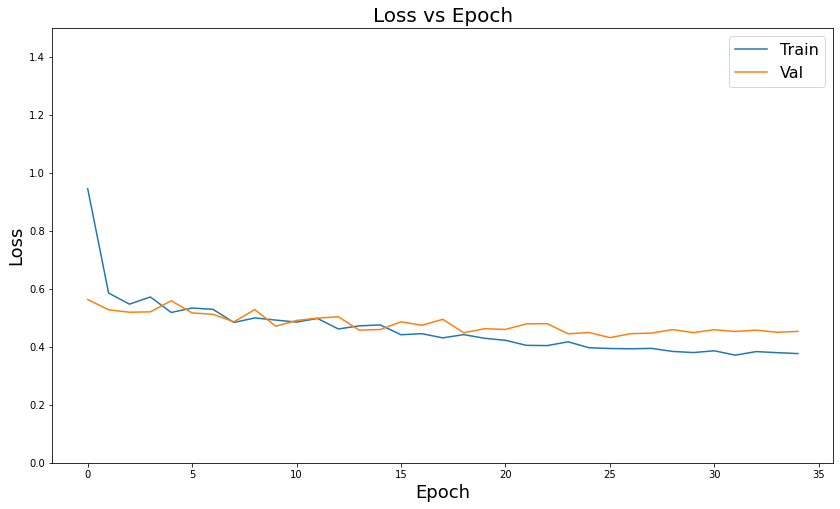

In [20]:
plt.figure(figsize=(14, 8))
plt.ylim(0,1.5)
sns.lineplot(list(range(len(train_loss))), train_loss)
sns.lineplot(list(range(len(valid_loss))), valid_loss)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(['Train','Val'], fontsize=16)
plt.title('Loss vs Epoch', fontsize=20)
plt.savefig(plots_folder/'loss.jpg')

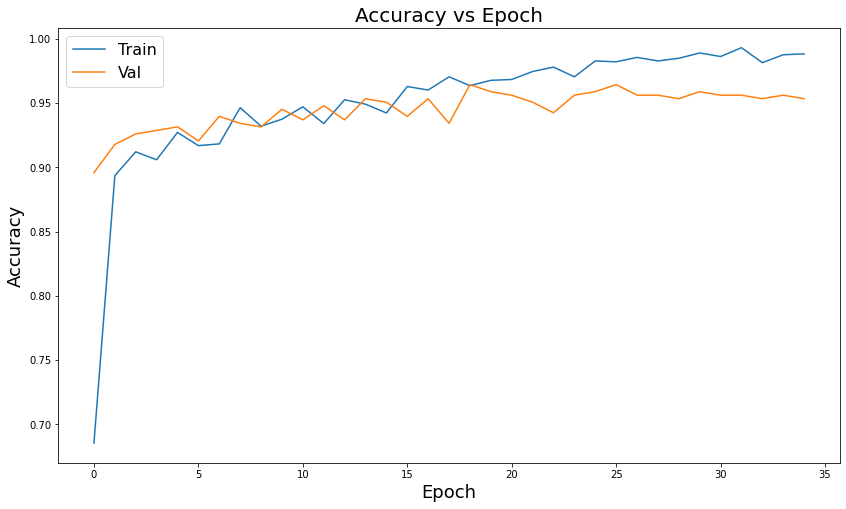

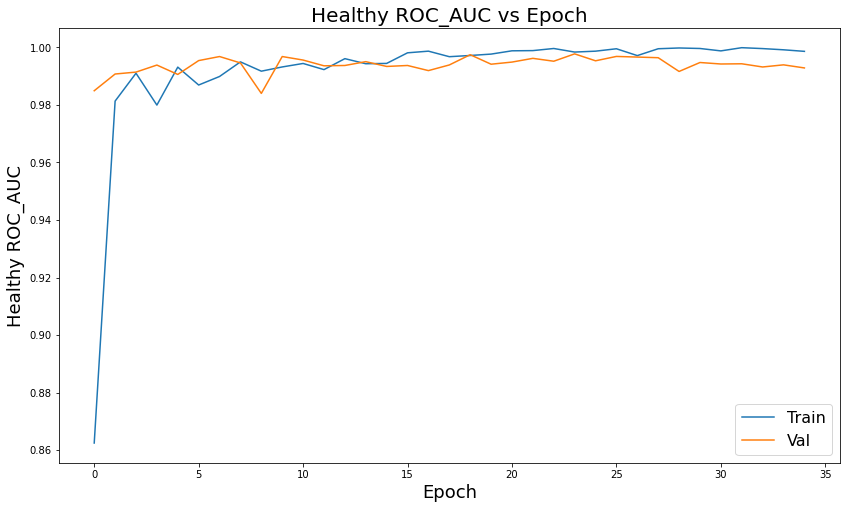

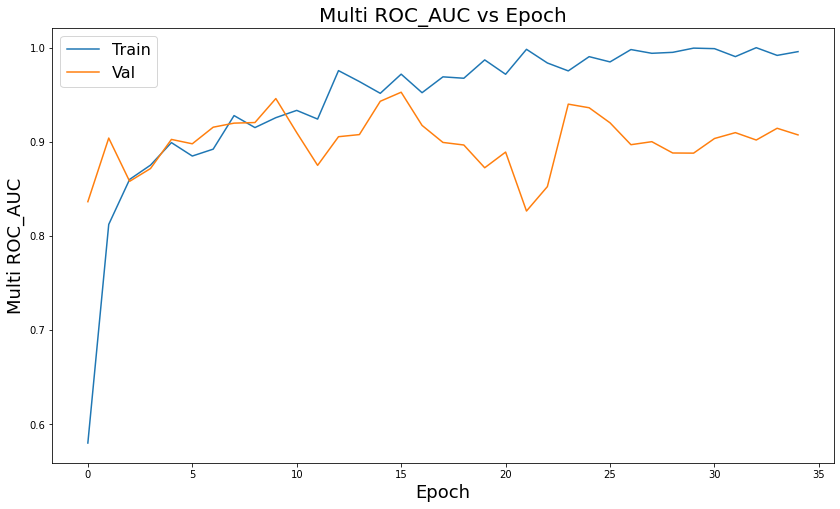

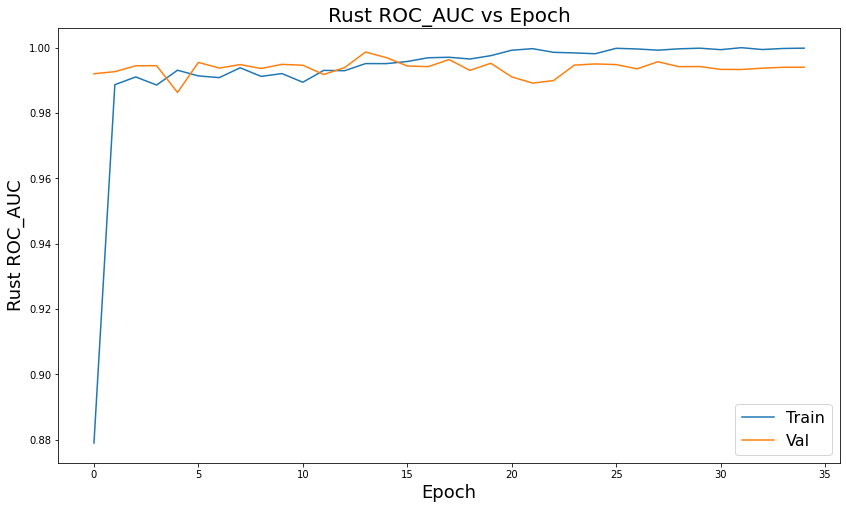

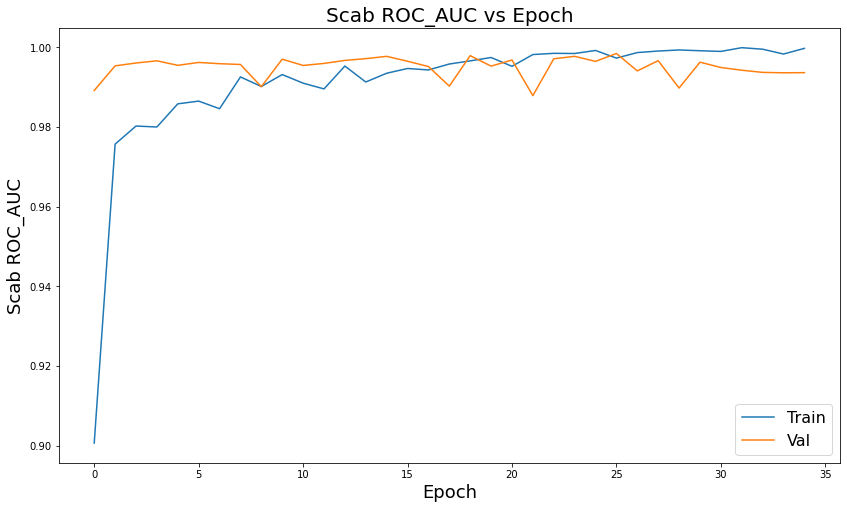

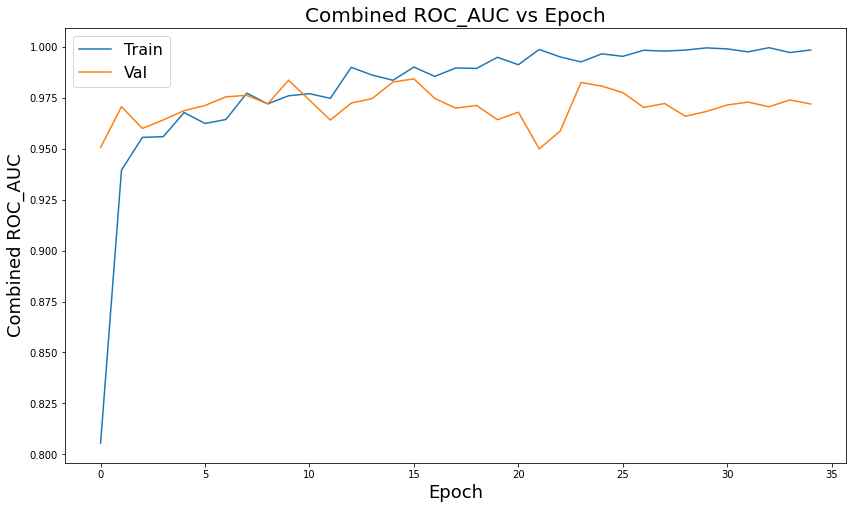

In [21]:
acc_names = ['Accuracy', 'Healthy ROC_AUC', 'Multi ROC_AUC', 'Rust ROC_AUC', 'Scab ROC_AUC', 'Combined ROC_AUC']
for idx, acc_name in enumerate(acc_names):
    plt.figure(figsize=(14, 8))
    sns.lineplot(list(range(len(train_acc[:, idx]))), train_acc[:, idx])
    sns.lineplot(list(range(len(val_acc[:, idx]))), val_acc[:, idx])
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel(acc_name, fontsize=18)
    plt.legend(['Train','Val'], fontsize=16)
    plt.title(f'{acc_name} vs Epoch', fontsize=20)
    plt.savefig(plots_folder/f'{model.__class__.__name__}_{acc_name}.jpg')

In [ ]:
_, _, conf_mat = validation(best_model, validloader, loss_fn, acc_fns, confusion_matrix, device, VALID_SIZE)
labels = ['Healthy', 'Multiple','Rust','Scab']
plt.figure(figsize=(15, 10))
sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, annot=True)
plt.title('Confusion Matrix', fontsize=20)
plt.savefig(plots_folder/'confusion.jpg')

### Testing Performance

In [ ]:
def get_testing_output(model, device):
    model = model.to(device)
    subs = []
    for i in range(5): #average over 5 runs
        out = testing(model, testloader, device)
        output = pd.DataFrame(softmax(out,1), columns = ['healthy','multiple_diseases','rust','scab']) #the submission expects probability scores for each class
        output.drop(0, inplace = True)
        output.reset_index(drop=True,inplace=True)
        subs.append(output)

    sub_eff1 = sum(subs)/5
    return sub_eff1

### Model Emsembling

In [ ]:
densenet_checkpoint = get_densenet(train_labels, model_path='/home/anishwalawalkar/plant-pathology/model_checkpoints/DenseNet_best_smoothing.pt')
resnet_checkpoint = get_resnet(train_labels, model_path='/home/anishwalawalkar/plant-pathology/model_checkpoints/ResNet_best_smoothing.pt')

In [ ]:
sub_densenet = get_testing_output(densenet_checkpoint, device)
sub_resnet = get_testing_output(resnet_checkpoint, device)

In [ ]:
submission = 0.25 * sub_resnet + 0.75 * sub_densenet

In [ ]:
submission['image_id'] = test_df['image_id']

In [ ]:
submission.to_csv('submission.csv', index=False)

### Saliency Maps

In [ ]:
model = get_densenet(train_labels, model_path='/home/anishwalawalkar/plant-pathology/model_checkpoints/DenseNet_epoch_29.pt')

In [ ]:
class_names = ['Healthy', 'Multi', 'Rust', 'Scab']
y = [0, 1, 2, 3]
X = np.array([
    np.array(Image.open(str(train_df.iloc[1817]['img_file']))),
    np.array(Image.open(str(train_df.iloc[1]['img_file']))),
    np.array(Image.open(str(train_df.iloc[1819]['img_file']))),
    np.array(Image.open(str(train_df.iloc[0]['img_file']))),
])

In [ ]:
show_saliency_maps(X, y, model, class_names, device)

### Class Visualization

In [ ]:
model = get_densenet(train_labels, model_path='/home/anishwalawalkar/plant-pathology/model_checkpoints/DenseNet_epoch_29.pt')

In [ ]:
create_class_visualization(y[3], model, device, class_names)